This page is taking over the functionality of ongoing_workspace.ipynb, so that I can import the data frame as it is currently saved, and run things more efficiently, now that Tasks 1-4 are complete. 

In [1]:
# Preamble - imports 
import numpy as np
import pandas as pd  
import data_cleaning_for_EDA as dc 
import matplotlib.pyplot as plt
import seaborn as sns
import imputing_methods as im 

In [2]:
# Preamble - Multiple Inheritance Class 
class MultipleInheritanceTestClass(im.Plotter, im.DataFrameTransform, dc.DataFrameInfo):
    def export_to_csv(self, filename):
        self.data_frame.to_csv(filename, index=False)
        print(f"DataFrame exported to {filename}")

In [ ]:
# Preamble - data read in
df_df = pd.read_csv("df_end_of_Task_4.csv")
# ensure it's a data frame at this stage so everything inherits correctly in the next step. 
type(df_df)


In [ ]:
df = MultipleInheritanceTestClass(df_df)

## Task 5: Remove outliers  
(Let the record show that as a statistician I do not condone willfully ignoring extereme-yet-possible data! I do so for the purposes of this task.)

Step 1: Visualise with Plotter class to determine if coumns contain outliers. 
I think the best way to indicate that something is an outlier is to plot the actual values against the expected values (were the data Gaussian) in a QQNorm plot. However, since I already plotted loads of this data and identified many non-Gaussian-looking distributions (that's even after "skew adjustment," another statistically questionable practise), I don't think a Normal QQ plot would tell me anything meaningful about outliers. 

I think the best I can offer right now is a box plot. It turs out there's a handy showfliers argument in the sns.boxplot() method-- see Plotter class, where I've added the boxplot_with_outliers() method. 

In [ ]:
# Troubleshooting checks 
print(type(df))

print(type(df.col_names()))

df.stats()



In [ ]:
column_names = df.col_names()

for column in column_names:
        print(f"Plotting boxplot for {column}:")
        df.boxplot_with_outliers(column)


So many of the distributions of these columns struck me as Non-Gaussian to begin with (e.g. exponential or poisson could fit a lot of this data, since we are literally counting "how many accounts have this quality?" and the number of accounts accrues as time passes.), so the concept of using 1.5*IQR as the defining "distance from the quartile" for outliers (which is what sbn.boxplot() does) may not be appropriate. If I see a boxplot has 50 "outliers," they're not really outliers, are they? However, these boxplots give me an initial visual so if I see anything that's truly separate from the pack, I can consider removing it. 

I also won't be removing anything from the id or member_id columns, since these aren't *really* quantitative data. 

So, items to consider removing, depending on how many are there: 


*collection_recovery_fee - has roughly four values higher than 5.5K, but honestly the way the plot tapers suggests exponential/poisson distribution so I wouldn't cut these off willy nilly. 

*recoveries - similar to the above, for values above 17500 

*total_rec_late_fee - because the density is so much more powerful and drops off so suddenly after 150, I'd be more inclined to remove the four or so that are greater than 150 in this column. 

*total_rec_int - there's one that's probably a couple hundred higher than the rest, but the tapering of frequencies shown in this plot suggests another poisson. 

total_accounts - I could consider removing the 5 that are about 85-ish, or just the 2 that are above 90. There's still evidence of tapering which calls the legitimacy of dropping outliers into question. 

open_accounts - clearly discrete dta, with 5 above 45 and 2 above 50, and the thickness of the circles indicates tapering, i.e. a poisson-style distribution. As the values are all fairly close to each other, I wouldn't be inclined to remove any of those. 

*inq_last_6mths - the four above 22 are quite 'gapped' away from the rest, especially the three above 30. 

*deling_2yrs - looks like tapering to me. we'll see how spikey the values above 15 look in a histogram. 

Next I'll examine histograms for the columns with stars, above, to deterimine if in fact the "outliers" the box plot highlighted were isolated and far from the trend, or simply the natural tails of a tapering distribution. 

In [ ]:
spiky_columns = list({"collection_recovery_fee", "recoveries", "total_rec_late_fee", "total_rec_int", "inq_last_6mths","delinq_2yrs"}) 
print(type(spiky_columns))

After much nashing of teeth and growling in an attempt to turn each histogram's y-axis (which is strictly frequency density), a friend suggested I just look at a table to help me judge how far out and unexpected the one-off's are. Let's see if this works... the table() method is added to the Plotter class... 

In [ ]:
for column in spiky_columns: 
    print(f"Table for {column}:")
    df.table(column)

Going to re-examine for a notable gap in some of the tables that were too long to examine from the above. 

In [ ]:
for column in spiky_columns:
        print(f"Plotting boxplot for {column}:")
        df.boxplot_with_outliers(column)

Right, plan of action for outliers has been formed... 

Of those reviewed above, here are my comments on what outliers to remove: 

- collection_recovery_fee - looks like they're all counts of 1 (for a total of just a handful) so just cut off anything bigger than 5000
- recoveries - looks like they're all counts of 1 so cut off anything bigger than 18000
- total_rec_late_fee - cut off anything bigger than 200 
- total_rec_int -  looks like they're all 1's but quite close together for a long time, so cut off the top four, i.e. anything bigger than 21500  
- inq_last_6mths - I can remove the four above 20. 
- deling_2yrs - None of those seem far enough away from a poisson-type distribution to justify dropping off. 

I'll also want to know how many data points I lose as a result of all these cut-offs. I'll be removing roughly 4 from each of the columns above, so if my loss of data points amounts to less than 20, I'll know some of those values were related by virtue of being part of the same data point (which suggests they could have been leverage points, but oh well.). 

In [ ]:
df.print_shape()
df.remove_outlier_rows('collection_recovery_fee', 5000)
df.print_shape() # lost 7

In [ ]:
df.remove_outlier_rows('recoveries', 18000)
df.print_shape() # lost 4

In [ ]:
df.print_shape()
df.remove_outlier_rows('total_rec_late_fee', 200)
df.print_shape() # lost 2

In [ ]:
df.remove_outlier_rows('total_rec_int', 21500)
df.print_shape() # lost 4

In [ ]:
df.remove_outlier_rows('inq_last_6mths', 20)
df.print_shape() # lost 4

It's promising to see from the losses above that there wasn't any overlap, so we moved simple outliers rather than leverage points. 
I'd now like to save this data frame for the next task. 

In [ ]:
df.export_to_csv("df_end_of_Task_5.csv")

## Task 6: Dropping overly correlated columns 

In [3]:
df_2 = pd.read_csv("df_end_of_Task_5.csv")
# ensure it's a data frame at this stage so everything inherits correctly in the next step. 
type(df_2)

pandas.core.frame.DataFrame

In [4]:
df = MultipleInheritanceTestClass(df_2)

First tasked with examining high-correlation pairs of columns. See the corr_matrix() method in DataFrameInfo(), from data_cleaning_for_EDA module. 

In [ ]:
# this method will produce a load of pngs to display scatterplots... repo, prepare for a file dump. XD 
df.corr_matrix() #default is 0.65 as a high correlation threshold; I'm happy with that for a start. 

Kindly examine the png files now in this repo if you'd like to see scatterplots of the high-correlation columns to remove. 

Naturally, if you remove all high correlation columns, then you lose meaningful information. That is, if A and B are both related to C, but A and B are highly correlated with each other, then if you remove both A and B, you lose information on the relationship to C. 

By looking for the most frequent and eggregious "offenders" of colinearity among those plots, I identified the following as possible columns to remove: 
- funded_amount 
- out_prncp 
- id or member_id (they're basically identical; I just want to check which one has a nicer distrubtion, and I'll keep that one.) 
- total_payment 
- total_rec_prncp 

My eyeballs doesn't feel like a rigorous enough decision making tool with so many high correlation pairs to examine (thoguh I'm fairly certain there are duplicates, i.e. A vs B and B vs A are shown on separate plots), so I will scour the internet for a more meaningful selection process.  

ChatGPT then gave me the idea that I need some criterion in order to decide which of two highly correlated columns to drop. I wonder if I can use the same logic as I'm using for id/member_id- and somehow code the method I'm creating to drop the more-skewed (for instance) of two columns. 

I'll start by visualising id and member_id, since I know what I'm looking for there... 

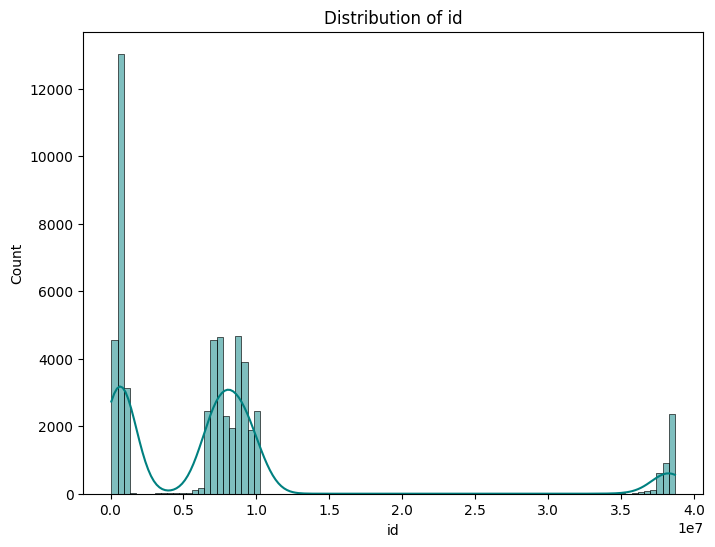

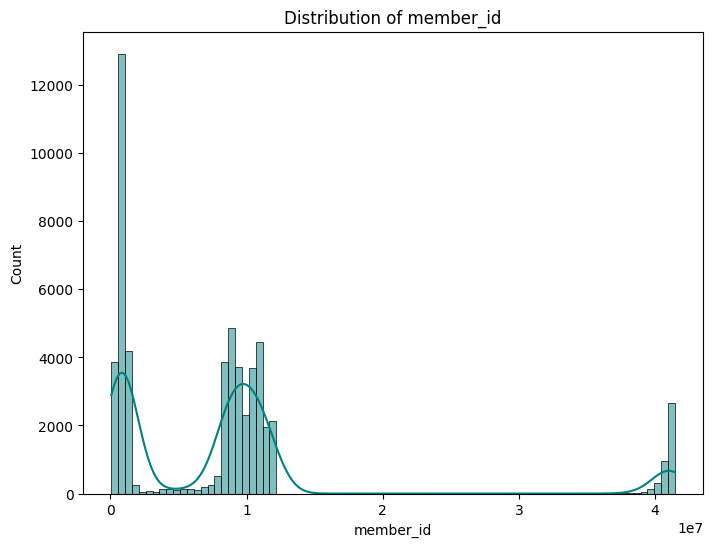

In [6]:
df.plot_column('id') 
df.plot_column('member_id')

Damn. They look way too similar to the human eye. Try skew?

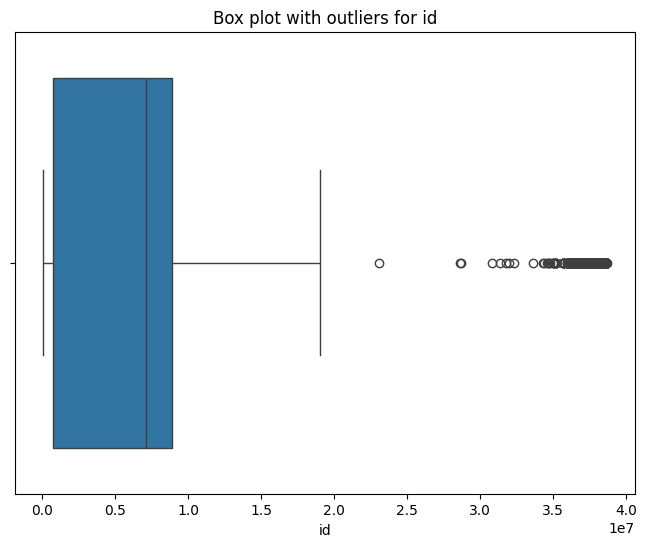

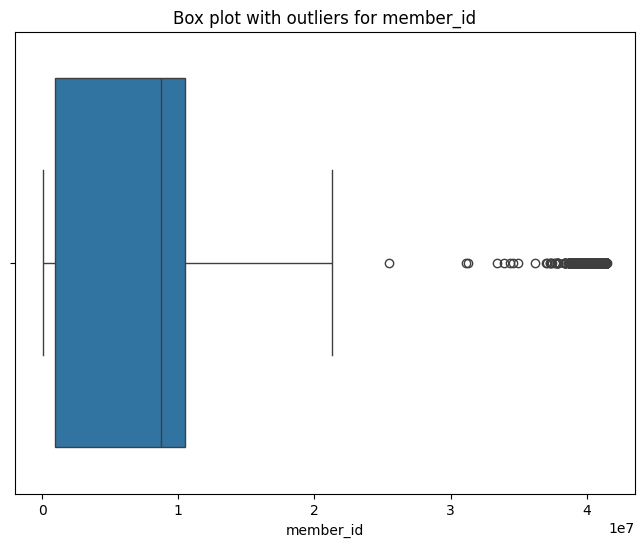

In [7]:
df.boxplot_with_outliers('id')
df.boxplot_with_outliers('member_id')


Even though member_id has a median marginally closer to the middle of the dataset, id simply seems to have a slightly more well-balanced inter-quartile range. Furthermore, looking at high_corr_scatterplot_id_vs_member_id, you can see that member_id measures 'jutt out' while id seems to trace a straight line more smoothly. Thus, I'll keep id and drop member_id. 

In [5]:
df.drop_any_column('member_id')

,Unnamed: 0,id,loan_amount,funded_amount,funded_amount_inv,term_length_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,0,38676116,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01 00:00:00,248.82,2022-02-01 00:00:00,2022-01-01 00:00:00,0.0,1,INDIVIDUAL
1,1,38656203,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01 00:00:00,407.52,2022-02-01 00:00:00,2022-01-01 00:00:00,0.0,1,INDIVIDUAL
2,2,38656154,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01 00:00:00,12850.16,NaT,2021-10-01 00:00:00,0.0,1,INDIVIDUAL
3,3,38656128,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01 00:00:00,13899.67,NaT,2021-06-01 00:00:00,0.0,1,INDIVIDUAL
4,4,38656121,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01 00:00:00,456.54,2022-02-01 00:00:00,2022-01-01 00:00:00,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54205,54226,76597,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01 00:00:00,160.61,NaT,2016-07-01 00:00:00,0.0,1,INDIVIDUAL
54206,54227,142608,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01 00:00:00,490.01,NaT,2016-09-01 00:00:00,0.0,1,INDIVIDUAL
54207,54228,117045,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01 00:00:00,110.58,2016-09-01 00:00:00,2013-05-01 00:00:00,0.0,1,INDIVIDUAL
54208,54229,88854,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01 00:00:00,0.00,NaT,2013-05-01 00:00:00,0.0,1,INDIVIDUAL
